## Initialization

In [1]:
# Get only the config file
import sys 
sys.path.insert(0, '../../notebofernando/')


In [2]:
# ensure relative imports are correctly imported
import sys
from configuration import *
sys.path.insert(0, '../qcore')

# Imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.QuantumMachine import QuantumMachine
from qm.qua import *

from instruments import LabBrick, MetaInstrument, Sa124, Stage, qm_config_builder

In [3]:
# Staging

stage_yaml_file_name = 'stage.yaml'
stage_yaml_file_path = Path.cwd() / stage_yaml_file_name

stage = Stage.load(stage_yaml_file_path)

device = stage.device_A
qubit = stage.device_A.qubit
rr = stage.device_A.rr
lb_qubit = stage.lb_qubit
lb_rr = stage.lb_rr
sa = stage.sa

# start the qm
qmm = QuantumMachinesManager()
qm = qmm.open_qm(config)

Trying to initialize lb_qubit
Connnected to LabBrick 25331
Setting initial parameters...
Successfully set frequency to 4.1650000E+09
Successfully set power to +15
LabBrick is ready to use.
Trying to initialize lb_rr
Connnected to LabBrick 25335
Setting initial parameters...
Successfully set frequency to 8.7571000E+09
Successfully set power to +13
LabBrick is ready to use.
Trying to initialize sa, will take about 5s...
Connnected to SA124B 19184645
Configured sweep! Sweep info: 
{'start': '7.7501000E+09', 'center': '8.0000000E+09', 'span': '5.000E+08', 'sweep_length': 2500, 'rbw': '2.500E+05', 'ref_power': 0, 'bin_size': '2.000E+05'}
2021-04-26 18:12:57,149 - qm - INFO - Performing health check
2021-04-26 18:12:57,160 - qm - INFO - Health check passed


In [5]:
#lb_qubit.disconnect()
#lb_rr.disconnect()
#sa.disconnect()

sa disconnected!


In [4]:
# We have tuned the IQ mixer according to the tutorial-2-2-SA124B-MixerTuning.ipynb document.
# These are key numbers obtained:
rr_dcOffsetI = 0.011558358245951837
rr_dcOffsetQ = -0.00947436793762317
rr_mixerGainCorrection = -0.15430981633780644
rr_mixerPhaseCorrection = 0.0212698142172309

q_dcOffsetI = -0.0030276985229423627
q_dcOffsetQ = -0.009971422329707026
q_mixerGainCorrection = -0.19547425898369505
q_mixerPhaseCorrection = 0.05154287262922243

# after this step we have tuned the IQ mixer.
qm.set_output_dc_offset_by_element("rr", "I", float(rr_dcOffsetI)) 
qm.set_output_dc_offset_by_element("rr", "Q", float(rr_dcOffsetQ))
qm.set_mixer_correction("mixer_rr", rr_IF, rr_LO, IQ_imbalance(rr_mixerGainCorrection, rr_mixerPhaseCorrection))
qm.set_output_dc_offset_by_element("qubit", "I", float(q_dcOffsetI)) 
qm.set_output_dc_offset_by_element("qubit", "Q", float(q_dcOffsetQ))
qm.set_mixer_correction("mixer_qubit", qubit_IF, qubit_LO, IQ_imbalance(rr_mixerGainCorrection, q_mixerPhaseCorrection))

## Pulse timing and manipulation

#### Prototype script

In [6]:
# QUA script
with program() as cw:
    with infinite_loop_():
        play("CW", "rr")


In [6]:
# Add script to queue
#job = qm.queue.add(cw)
#job.cancel()

2021-04-24 09:30:32,688 - qm - INFO - Flags: 
2021-04-24 09:30:32,689 - qm - INFO - Executing high level program


In [8]:
# Execute script
job = qm.execute(cw)
#job.halt()

2021-04-25 15:11:04,986 - qm - INFO - Flags: 
2021-04-25 15:11:04,986 - qm - INFO - Executing high level program


True

#### Pulse duration
The pulse duration can be defined inside the QUA script using either a python or QUA variable int.

The duration is given in clock cycles of 4ns. That is, setting a duration = 1000 will play a 4000 ns-long pulse (insert image 3). On the other hand, the duration value as set directly on the config file is in nanoseconds.

In [13]:
# QUA script
with program() as pulse_duration:
    
    length_rr = declare(int, value = 200)
    length_qubit = declare(int, value = 50)
    
    with infinite_loop_():
        play("CW", "rr", duration = length_rr)
        align("rr", "qubit")
        play("CW", "qubit", duration = length_qubit)


In [15]:
# Execute script
job = qm.execute(pulse_duration)
job.halt()

2021-04-25 15:15:18,170 - qm - INFO - Flags: 
2021-04-25 15:15:18,170 - qm - INFO - Executing high level program


True

#### Wait command
Similarly to the pulse duration, the wait command also uses clock-cycle units. (insert image 4)

In [43]:
# QUA script
with program() as wait_command:
    
    length_rr = declare(int, value = 200)
    length_qubit = declare(int, value = 50)
    wait_time = declare(int, value = 100)
    
    with infinite_loop_():
        play("CW", "rr", duration = length_rr)
        align("rr", "qubit")
        play("CW", "qubit", duration = length_qubit)
        wait(wait_time)


In [19]:
# Execute script
job = qm.execute(wait_command)
job.halt()

2021-04-25 15:24:23,988 - qm - INFO - Flags: 
2021-04-25 15:24:23,988 - qm - INFO - Executing high level program


True

#### Stretching and compressing arbitrary pulses

According to our tests, square pulses can be stretched and compressed in time arbitrarily, limited only by device constraints. 

Arbitrary pulses, as gaussian pulses, can be effectively stretched in time. QUA does this by interpolating the amplitude values, and thus it must be used with caution.

(image 5: 900 ns-long gaussian pulse as defined in config)
(image 7: 4000 ns-long gaussian pulse defined w/ duration = 1000)

Compressing pulses shows to be much less effective. Setting duration = 125 highly distorts the gaussian shape.
(image 8: 500 ns-long gaussian pulse defined w/ duration = 125)

In [16]:
# QUA script
with program() as wait_command:
    
    length_qubit = declare(int, value = 125)
    
    with infinite_loop_():
        play("CW", "rr", duration = 200)
        align("rr", "qubit")
        play("gaussian", "qubit", duration = length_qubit)
        wait(100)


In [17]:
# Execute script
job = qm.execute(wait_command)
# job.halt()

2021-04-25 15:18:10,668 - qm - INFO - Flags: 
2021-04-25 15:18:10,669 - qm - INFO - Executing high level program


## QUA control flow

#### for_each_() and for_() loops

These are the two QUA loop commands, each having its own structure but having a similar purpose.

for_each_() allows one to loop over a arbitrarily-defined list. This list might be either a python or QUA variable.

In [8]:
# QUA script
reps = 500000
with program() as cw:
    
    # Declares QUA variables
    n = declare(int)
    
    freq = declare(int)
    freq_list = declare(int, value = [int(-10e6), int(-50e6), int(-70e6)])
    
    with for_each_(freq, freq_list):
        update_frequency("rr", freq)
        with for_(n, 0, n < reps, n + 1):
            play("CW", "rr", duration = 500)
            wait(2000)


In [9]:
# Execute script
job = qm.execute(cw)
# job.halt()

2021-04-23 17:53:58,215 - qm - INFO - Flags: 
2021-04-23 17:53:58,216 - qm - INFO - Executing high level program


#### for_each_() loop over multiple arrays


In [16]:
# QUA script
reps = 500000
freq_q_list_py = [int(-10e6), int(-50e6), int(-70e6)]
freq_rr_list_py = [int(-10e6), int(-50e6), int(-70e6)]
with program() as cw:
    
    # Declares QUA variables
    n = declare(int)
    
    freq_q = declare(int)
    freq_rr = declare(int)
    freq_q_list = declare(int, value = freq_q_list_py)
    freq_rr_list = declare(int, value = freq_rr_list_py)
    
    with for_each_((freq_q, freq_rr), (freq_q_list, freq_rr_list)):
        update_frequency("rr", freq_rr)
        update_frequency("qubit", freq_q)
        with for_(n, 0, n < reps, n + 1):
            play("CW", "rr", duration = 500)
            align("rr", "qubit")
            play("CW", "qubit", duration = 100)
            wait(2000)


In [18]:
# Execute script
job = qm.execute(cw)
# job.halt()

2021-04-23 17:58:36,729 - qm - INFO - Flags: 
2021-04-23 17:58:36,730 - qm - INFO - Executing high level program


#### Going crazy with nested loops
Make sure that the types of python and QUA variables and arrays all match. Sometimes this bugs the script without raising a meaningful error message. Frequencies, durations and wait times are all integers.

In [29]:
# QUA script
reps = 50000
rr_f_vec_py = [int(x) for x in np.linspace(1e6, 50e6, 51)]

# All vectors used in the same for_each_ loop must have the same length. 
# Use np.mesh to create these if needed.
rr_a_vec_py = [0.1, 0.1, 0.5, 0.5]
qu_a_vec_py = [0.2, 0.3, 0.2, 0.3]
wt_vec_py = [20000, 20000, 20000, 20000]

with program() as cw:
    
    # Declares QUA variables
    n = declare(int)
    rr_f = declare(int)
    rr_a = declare(fixed)
    qu_a = declare(fixed)
    wt = declare(int)

    # Arrays for sweeping
    rr_f_vec = declare(int, value = rr_f_vec_py)
    rr_a_vec = declare(fixed, value = rr_a_vec_py)
    qu_a_vec = declare(fixed, value = qu_a_vec_py)
    wt_vec = declare(int, value = wt_vec_py)
    
    with for_(n, 0, n < reps, n + 1):
        with for_each_((wt, rr_a, qu_a), (wt_vec, rr_a_vec, qu_a_vec)):
            with for_each_(rr_f, rr_f_vec):
                update_frequency("rr", rr_f)
                play('saturation' * amp(qu_a), 'qubit')
                align('qubit', 'rr')
                play('CW' * amp(rr_a), 'rr', duration = 500)
                wait(wt, "rr")

In [32]:
# Execute script
job = qm.execute(cw)
job.halt()

2021-04-25 16:01:38,126 - qm - INFO - Flags: 
2021-04-25 16:01:38,126 - qm - INFO - Executing high level program


True

## Stream processing and data structure

#### Saving raw adc data
In this example, we will run a single 1000ns-long measurement. After time_of_flight, the OPX will register one voltage value per nanosecond for 1000ns. As we are saving all values with timestamps, the result will be an array of 1000 tuples containing the voltage reading and a timestamp.

The raw data is printed below. Notice that the data aquisition lasts as long as the measurement pulse, and that the time is in nanoseconds, not clock cycles. Also, it is very noisy due to low averaging.

In [73]:
with program() as raw_adc:
    my_stream1 = declare_stream(adc_trace=True)
    measure('long_readout', 'rr', my_stream1)
    with stream_processing():
        my_stream1.input1().with_timestamps().save('adc_results')
        #my_stream1.input1().save('adc_results') # Saving without timestamps

<ipython-input-73-f484036dbe86>:5: QMDeprecationWarning: _ResultSource.with_timestamps is deprecated since 0.8: use timestamps() instead to create a stream of timestamps
  my_stream1.input1().with_timestamps().save('adc_results')


In [74]:
# Execute script
job = qm.execute(raw_adc)
# job.halt()

2021-04-25 18:47:03,287 - qm - INFO - Flags: 
2021-04-25 18:47:03,288 - qm - INFO - Executing high level program


In [75]:
# print results saved in adc_results
results = job.result_handles.get('adc_results').fetch_all()
print('shape = ', results.shape)
print('\n(value, timestamp) = \n', results)

shape =  (1000,)

(value, timestamp) = 
 [(-65, 1028) (-59, 1029) (-62, 1030) (-66, 1031) (-64, 1032) (-64, 1033)
 (-63, 1034) (-64, 1035) (-65, 1036) (-68, 1037) (-64, 1038) (-68, 1039)
 (-66, 1040) (-65, 1041) (-65, 1042) (-64, 1043) (-66, 1044) (-62, 1045)
 (-59, 1046) (-57, 1047) (-59, 1048) (-65, 1049) (-62, 1050) (-59, 1051)
 (-62, 1052) (-61, 1053) (-59, 1054) (-59, 1055) (-59, 1056) (-59, 1057)
 (-56, 1058) (-56, 1059) (-59, 1060) (-60, 1061) (-58, 1062) (-61, 1063)
 (-61, 1064) (-60, 1065) (-64, 1066) (-64, 1067) (-59, 1068) (-60, 1069)
 (-57, 1070) (-59, 1071) (-58, 1072) (-60, 1073) (-62, 1074) (-61, 1075)
 (-61, 1076) (-61, 1077) (-58, 1078) (-56, 1079) (-59, 1080) (-61, 1081)
 (-64, 1082) (-53, 1083) (-54, 1084) (-57, 1085) (-58, 1086) (-63, 1087)
 (-61, 1088) (-59, 1089) (-56, 1090) (-56, 1091) (-58, 1092) (-61, 1093)
 (-58, 1094) (-58, 1095) (-63, 1096) (-60, 1097) (-58, 1098) (-57, 1099)
 (-57, 1100) (-58, 1101) (-60, 1102) (-56, 1103) (-52, 1104) (-56, 1105)
 (-56, 110

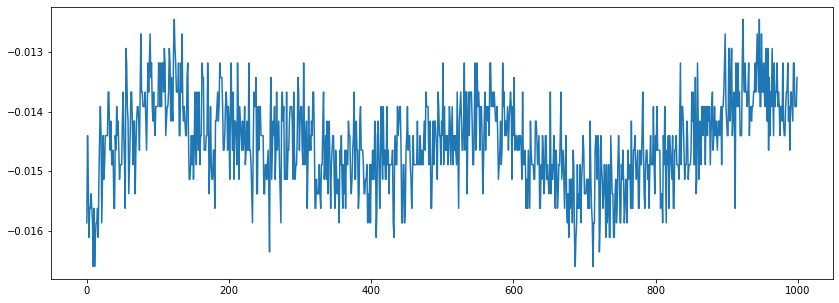

In [76]:
# Division by 2**12 is necessary to convert ADC data to volts.
plt.figure(figsize = (14,5))
plt.plot([x[0]/2**12 for x in results])

#### Averaging
Let us repeat this experiment 30k times. 

The .average() command was added to stream processing, and it automatically divides the data into chunks of 1000ns and average them (no buffering is needed).

For averaging raw data, it is also necessary to use reset_phase() so that the pulses can sum up coherently.

A wait command of 20k clock cycles is included between every repetition so the cavity has enough time to relax to its initial condition.

FFT of the data is saved using the .fft() command.

Not adding .average() will result in only one repetition being output to the results (probably because .save() only saves the latest result. Maybe using save_all would allow accessing all runs individually).

Not sure if this can be done with timestamps.

In [69]:
reps = 100000
with program() as raw_adc_avg:
    my_stream1 = declare_stream(adc_trace=True)
    n = declare(int)
    
    with for_(n, 0, n < reps, n + 1):
        reset_phase("rr")
        measure('long_readout'*amp(1.), 'rr', my_stream1)
        wait(20000, "rr")
        
    with stream_processing():
        my_stream1.input1().average().save('adc_results')
        my_stream1.input1().average().fft().save('adc_fft')

In [70]:
# Execute script
job = qm.execute(raw_adc_avg)
#job.halt()

2021-04-25 17:17:33,373 - qm - INFO - Flags: 
2021-04-25 17:17:33,373 - qm - INFO - Executing high level program


In [71]:
# print results saved in adc_results
results = job.result_handles.get('adc_results').fetch_all()
print('shape = ', results.shape)
print('\n(value, timestamp) = \n', results)

shape =  (1000,)

(value, timestamp) = 
 [-60.12881356 -60.25875706 -60.3220339  -60.18757062 -60.18079096
 -60.0960452  -60.2440678  -60.09265537 -59.94689266 -59.94915254
 -60.03163842 -59.93446328 -60.01016949 -60.10847458 -60.04632768
 -60.04519774 -60.03163842 -60.05875706 -60.19322034 -60.19435028
 -59.97062147 -60.05875706 -60.0960452  -60.21016949 -60.06440678
 -60.18644068 -60.16836158 -60.10508475 -60.14011299 -60.13785311
 -60.09378531 -60.18079096 -60.21129944 -60.00903955 -60.0519774
 -60.0779661  -60.09152542 -60.06214689 -60.19096045 -60.13446328
 -60.1740113  -60.19548023 -60.19887006 -60.15254237 -60.10960452
 -60.26892655 -60.12768362 -60.10169492 -60.16497175 -60.0259887
 -60.12429379 -60.22146893 -60.0519774  -59.91186441 -60.09943503
 -59.93559322 -59.88022599 -59.95367232 -59.97514124 -59.95141243
 -60.0259887  -60.05536723 -60.03389831 -59.96949153 -59.9819209
 -60.08135593 -59.90621469 -59.9920904  -60.1220339  -60.08135593
 -60.08926554 -60.09265537 -60.0203389

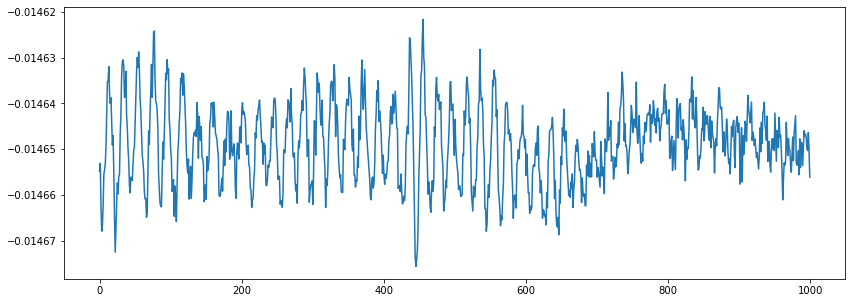

In [27]:
plt.figure(figsize = (14,5))
plt.plot(results/2**12)

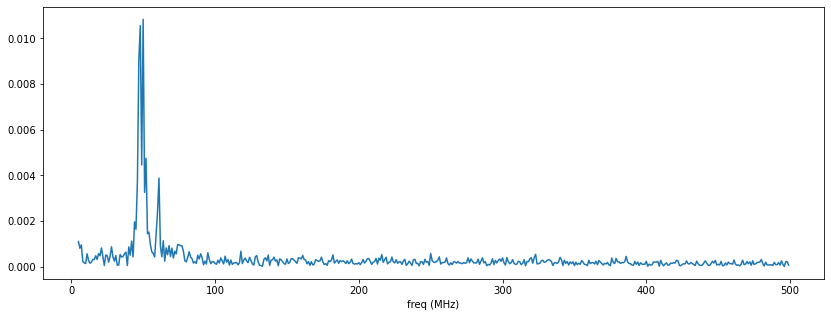

In [30]:
# Retrieving and plotting FFT data.
results_fft = job.result_handles.get('adc_fft').fetch_all()
plt.figure(figsize = (14,5))
pulse_len = 1000 # pulse len in nanoseconds

results_fft = np.sqrt(np.sum(np.squeeze(results_fft) ** 2, axis=1)) / pulse_len
freqs = np.arange(0, 0.5, 1 / pulse_len)[:]*1e9 
amps = results_fft[: int(np.ceil(pulse_len / 2))]
plt.plot(freqs[5:]/1e6, amps[5:])
plt.xlabel('freq (MHz)')
plt.show()


#### Getting I and Q from integrated ADC data

The measurement command can be used to directly integrate the ADC data and output single I and Q values.

The stream in which to save the raw ADC data is set to None. The integration weigths and variables are defined in demod.full.

In [77]:
with program() as integrate_IQ:
    
    I = declare(fixed)
    Q = declare(fixed)
    
    I_st = declare_stream()
    Q_st = declare_stream()
    
    measure("long_readout", "rr", None, 
            demod.full('long_integW1', I), 
            demod.full('long_integW2', Q))
    
    save(I, I_st)
    save(Q, Q_st) 
    
    
    with stream_processing():
        I_st.save('I')
        Q_st.save('Q')


In [78]:
# Execute script
job = qm.execute(integrate_IQ)
# job.halt()

2021-04-25 18:49:02,864 - qm - INFO - Flags: 
2021-04-25 18:49:02,865 - qm - INFO - Executing high level program


In [79]:
# print results saved in adc_results
I_results = job.result_handles.get('I').fetch_all()
Q_results = job.result_handles.get('Q').fetch_all()
print('I = ', I_results)
print('Q = ', Q_results)

I =  -1.8071383237838745e-05
Q =  2.1979212760925293e-05


#### Buffering I and Q

First note that it is possible to explicitely save all measurements of I and Q using .save_all() command within the stream_processing environment (ikr). Using .save() will only store the latest results

In [152]:
reps = 10
with program() as buffering_IQ:
    
    n = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    
    I_st = declare_stream()
    Q_st = declare_stream()
    
    with for_(n, 0, n < reps, n + 1):
        measure("long_readout", "rr", None, 
                demod.full('long_integW1', I), 
                demod.full('long_integW2', Q))
        save(I, I_st)
        save(Q, Q_st) 
        wait(20000, 'rr')
    
    
    with stream_processing():
        I_st.save_all('I')
        Q_st.save_all('Q')


In [153]:
# Execute script
job = qm.execute(buffering_IQ)
# job.halt()

2021-04-25 11:35:54,537 - qm - INFO - Flags: 
2021-04-25 11:35:54,538 - qm - INFO - Executing high level program


In [154]:
# print results saved in adc_results
I_results = job.result_handles.get('I').fetch_all()
Q_results = job.result_handles.get('Q').fetch_all()
print('I = ', I_results)
print('Q = ', Q_results)

I =  [(-2.08131969e-05,) ( 2.02544034e-05,) (-2.20797956e-05,)
 ( 2.36816704e-05,) (-2.28881836e-05,) ( 1.51917338e-05,)
 (-1.61007047e-05,) ( 3.15569341e-05,) (-1.89542770e-05,)
 ( 2.16849148e-05,)]
Q =  [(-1.52103603e-05,) ( 8.36700201e-06,) (-1.09113753e-05,)
 ( 8.70972872e-06,) (-1.40741467e-05,) ( 1.18538737e-05,)
 (-1.26622617e-05,) ( 8.84011388e-06,) (-1.03265047e-05,)
 ( 1.52625144e-05,)]


Now let us add an inner loop in measurement frequency and reshape the results in an intelligible way using .buffer()

In [156]:
reps = 10
f_vec = [int(10e6), int(50e6)]
buffer_len = len(f_vec)

with program() as buffering_IQ:
    
    n = declare(int)
    f = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    
    I_st = declare_stream()
    Q_st = declare_stream()
    
    with for_(n, 0, n < reps, n + 1):
        with for_each_(f, f_vec):
            measure("long_readout", "rr", None, 
                    demod.full('long_integW1', I), 
                    demod.full('long_integW2', Q))
            save(I, I_st)
            save(Q, Q_st) 
            wait(20000, 'rr')
    
    
    with stream_processing():
        I_st.buffer(buffer_len).save_all('I')
        Q_st.buffer(buffer_len).save_all('Q')

In [157]:
# Execute script
job = qm.execute(buffering_IQ)
# job.halt()

2021-04-25 11:42:10,115 - qm - INFO - Flags: 
2021-04-25 11:42:10,116 - qm - INFO - Executing high level program


In [167]:
# print results saved in adc_results
I_results = job.result_handles.get('I').fetch_all()
print('I = ', I_results)

I =  [([ 1.57430768e-05, -7.39097595e-06],)
 ([ 2.26795673e-05, -2.48998404e-05],)
 ([-1.25095248e-05,  3.53157520e-06],)
 ([-2.30856240e-05,  2.64532864e-05],)
 ([ 9.74535942e-06, -3.49432230e-06],)
 ([ 2.19084322e-05, -2.10329890e-05],)
 ([ 7.10040331e-06,  5.04776835e-06],)
 ([-2.35028565e-05,  2.10776925e-05],)
 ([-6.17280602e-06, -4.82425094e-06],)
 ([ 2.87964940e-05, -1.90809369e-05],)]


The result above is a 2D array, with the first dimension corresponding to the outer loop (repetitions) and the second dimension corresponding to the inner loop (frequencies). The second dimension is bidimensional because we told it to be using .buffer(buffer_len).

However, this data is hard to access because it is enveloped in nasty tuples. We can fix that and get a nice ndarray by setting the flat_struct tag:

In [169]:
I_results = job.result_handles.get('I').fetch_all(flat_struct=True)
print('I = ', I_results)

I =  [[ 1.57430768e-05 -7.39097595e-06]
 [ 2.26795673e-05 -2.48998404e-05]
 [-1.25095248e-05  3.53157520e-06]
 [-2.30856240e-05  2.64532864e-05]
 [ 9.74535942e-06 -3.49432230e-06]
 [ 2.19084322e-05 -2.10329890e-05]
 [ 7.10040331e-06  5.04776835e-06]
 [-2.35028565e-05  2.10776925e-05]
 [-6.17280602e-06 -4.82425094e-06]
 [ 2.87964940e-05 -1.90809369e-05]]


#### Multi-variable buffering

Let us now include a variable pulse amplitude in the loop.

We want to include both f and amp sweeps in a single for_each_ loop, so it is first necessary to use np.meshgrid(). The indexing = 'ij' tag guarantees that the lists passed as parameters are in the order from outer to inner loop.

Remember to convert frequencies back to integers after doing the meshgrid. Otherwise QUA might complain.

In [222]:
f_vec = [int(10e6), int(50e6)]
amp_vec = [0.01, 0.20, 1.0]
parameter_list = [(x.flatten()) 
                  for x in np.meshgrid(f_vec, amp_vec, indexing = 'ij')]

f_vec_py = [int(x) for x in parameter_list[0]]
amp_vec_py = parameter_list[1]

print('f_vec_py = ', f_vec_py)
print('amp_vec_py = ', amp_vec_py)

f_vec_py =  [10000000, 10000000, 10000000, 50000000, 50000000, 50000000]
amp_vec_py =  [0.01 0.2  1.   0.01 0.2  1.  ]


In [223]:
reps = 10
buffer_len_f = len(f_vec)
buffer_len_amp = len(amp_vec)

with program() as multiple_var_buffer:
    
    n = declare(int)
    f = declare(int)
    a = declare(fixed)
    I = declare(fixed)
    Q = declare(fixed)
    
    f_vec_qua = declare(int, value = f_vec_py)
    amp_vec_qua = declare(fixed, value = amp_vec_py)
    
    I_st = declare_stream()
    Q_st = declare_stream()
    
    with for_(n, 0, n < reps, n + 1):
        with for_each_((f, a), (f_vec_qua, amp_vec_qua)):
            measure("long_readout", "rr", None, 
                    demod.full('long_integW1', I), 
                    demod.full('long_integW2', Q))
            save(I, I_st)
            save(Q, Q_st) 
            wait(20000, 'rr')
    
    
    with stream_processing():
        I_st.buffer(buffer_len_f, buffer_len_amp).save_all('I')
        Q_st.buffer(buffer_len_f, buffer_len_amp).save_all('Q')

In [224]:
# Execute script
job = qm.execute(multiple_var_buffer)
# job.halt()

2021-04-25 13:06:49,915 - qm - INFO - Flags: 
2021-04-25 13:06:49,916 - qm - INFO - Executing high level program


I_results.shape = (10, 2, 3), which means the first dimension is the repetition, the second is frequency and the third is amplitude. In order for this to work, you must make sure the buffering lengths are in the same order as the loop.

In [225]:
I_results = job.result_handles.get('I').fetch_all(flat_struct=True)
print(I_results.shape)
print('I = ', I_results)

(10, 2, 3)
I =  [[[ 1.05276704e-05 -1.33849680e-05  8.97049904e-06]
  [-7.94231892e-06  1.79000199e-05 -8.95559788e-06]]

 [[ 2.12639570e-05 -1.98297203e-05  1.98818743e-05]
  [-2.45869160e-05  1.71214342e-05 -2.34395266e-05]]

 [[-4.24683094e-07  9.67830420e-06 -1.12876296e-05]
  [ 9.70438123e-06 -2.96533108e-06  1.03823841e-05]]

 [[-2.68034637e-05  2.51084566e-05 -2.15061009e-05]
  [ 2.57566571e-05 -2.26125121e-05  2.21282244e-05]]

 [[ 4.00096178e-06 -5.39422035e-06  4.30643559e-06]
  [-4.10899520e-06  7.67782331e-06 -5.61401248e-06]]

 [[ 2.22921371e-05 -2.24672258e-05  2.77683139e-05]
  [-2.62334943e-05  2.08839774e-05 -2.35661864e-05]]

 [[-5.71832061e-06 -1.13993883e-06 -2.14204192e-06]
  [-3.78116965e-06 -6.82845712e-06  4.47034836e-07]]

 [[-2.58572400e-05  2.28397548e-05 -2.75634229e-05]
  [ 1.97105110e-05 -1.89058483e-05  2.32383609e-05]]

 [[-1.56089664e-06  2.50339508e-06  1.10268593e-06]
  [ 2.11223960e-06  3.03611159e-06  3.45706940e-06]]

 [[ 2.54549086e-05 -1.97216868

It is possible to take the average of each of the 10 (2,3)-matrices with stream processing. You simply need to add .average() after the buffer, and use .save() instead of .save_all() to get only the consolidated average.

Note that using .save_all() would give you the evolution of the average with the accumulation of repeated measurements.

In [229]:
reps = 10
f_vec = [int(10e6), int(50e6)]
amp_vec = [0.01, 0.20, 1.0]
buffer_len_f = len(f_vec)
buffer_len_amp = len(amp_vec)

parameter_list = [(x.flatten()) 
                  for x in np.meshgrid(f_vec, amp_vec, indexing = 'ij')]

f_vec_py = [int(x) for x in parameter_list[0]]
amp_vec_py = parameter_list[1]


with program() as multiple_var_avg:
    
    n = declare(int)
    f = declare(int)
    a = declare(fixed)
    I = declare(fixed)
    Q = declare(fixed)
    
    f_vec_qua = declare(int, value = f_vec_py)
    amp_vec_qua = declare(fixed, value = amp_vec_py)
    
    I_st = declare_stream()
    Q_st = declare_stream()
    
    with for_(n, 0, n < reps, n + 1):
        with for_each_((f, a), (f_vec_qua, amp_vec_qua)):
            measure("long_readout", "rr", None, 
                    demod.full('long_integW1', I), 
                    demod.full('long_integW2', Q))
            save(I, I_st)
            save(Q, Q_st) 
            wait(20000, 'rr')
    
    
    with stream_processing():
        I_st.buffer(buffer_len_f, buffer_len_amp).average().save('I')
        Q_st.buffer(buffer_len_f, buffer_len_amp).average().save('Q')

In [230]:
# Execute script
job = qm.execute(multiple_var_avg)
# job.halt()

2021-04-25 13:46:44,005 - qm - INFO - Flags: 
2021-04-25 13:46:44,006 - qm - INFO - Executing high level program


In [232]:
I_results = job.result_handles.get('I').fetch_all(flat_struct=True)
print(I_results.shape)
print('I = ', I_results)

(2, 3)
I =  [[ 1.4949590e-06 -2.1215528e-06  3.1292439e-06]
 [-4.1507185e-06  2.8811395e-06 -4.0087849e-06]]
